In [1]:
# Importando o framework para predição das imagens
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
# Importando bibliotecas para analises de imagens
import cv2
import imgaug as im
from PIL import Image

# Importando bibliotecas do sistema
import os
import base64

# Importa biblioteca para rede neural
import keras
import segmentation_models as sm
from sklearn import metrics

# Importa bibliotecas para analise de dados
import pandas as pd
import numpy as np

# Importa bibliotecas para visualização de dataframes com imagens
import pdfkit as pdf
from io import BytesIO
from IPython.display import HTML


Segmentation Models: using `tf.keras` framework.


In [15]:
path_name_image = 'D:/Sensix/Python/img_generated/img_original/sugarcane/rgb/'
path_name_image_md = 'D:/Sensix/Python/img_generated/img_original/sugarcane/ground-truth/'

model = sm.Linknet('vgg16', encoder_weights='imagenet')
model_2 = sm.Linknet('vgg16', encoder_weights='imagenet')
model_3 = sm.Linknet('vgg16', encoder_weights='imagenet')

model.load_weights('D:/Sensix/Python/Redes Neurais/diverses_backbones/segment_weed_2.h5')
model_2.load_weights('D:/Sensix/Python/Redes Neurais/marcacoes_externas/vgg16_Linknet_2.hdf5')
model_3.load_weights('D:/Sensix/Python/Redes Neurais/marcacoes_filtro_verde/vgg16_Linknet_Test13.hdf5')

In [17]:
original_img = []

binary_marked = []
binary_model_0 = []
binary_model_1 = []
binary_model_2 = []

real = []
real_marked = []
real_model_0 = []
real_model_1 = []
real_model_2 = []

name_model = ['model','model_2', 'model_3']


In [18]:

for name_image, j in zip(os.listdir(path_name_image), range(5)):
    image_rgb = cv2.imread(path_name_image + name_image)
    image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB) / 255
    original_img.append(image_rgb)

    img = np.array(image_rgb)
    img = img * 255
    img = img.astype(np.uint8)

    real.append(img)
        
    for i in range(3): 
        image = image_rgb.copy()
        pred = eval(str(name_model[i]) + '.predict(np.array([image_rgb]))[0]')
        pred = np.array(pred)
        pred = pred[:,:,0]

        pred[pred > 0.1] = 1
        pred[pred < 0.1] = 0
        
        eval('binary_model_' + str(i) + '.append(pred)')

        image = image * 255
        image[pred == 1] = [255,0,0]
        image = image.astype(np.uint8)

        eval('real_model_' + str(i) + '.append(image)')
        
        del pred, image
        

In [19]:
for name_image_md, i in zip(os.listdir(path_name_image_md), range(len(original_img))):
    image_rgb = cv2.imread(path_name_image_md + name_image_md)
    
    image = image_rgb.copy()
    image = np.array(image)
    image = image[:,:,0]

    image[image < 1 ] = 0
    image[image >= 1] = 1
    real_img = original_img[i]

    binary_marked.append(image)

    real_img = real_img * 255   
    real_img[image == 1] = [255,0,0]
    real_img = real_img.astype(np.uint8)
    
    real_marked.append(real_img)

In [21]:
def get_thumbnail(path):
    i = Image.fromarray(path)
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

In [22]:
dict_predict_images = {'path_imgs': real, 'path_marked': real_marked, 'path_model_0': real_model_0, 'path_model_1': real_model_1, 'path_model_2': real_model_2}

In [23]:
df = pd.DataFrame(dict_predict_images)

In [24]:
df['imgs'] = df.path_imgs.map(lambda f: get_thumbnail(f))
df['imgs_marked'] = df.path_marked.map(lambda f: get_thumbnail(f))
df['model_0'] = df.path_model_0.map(lambda f: get_thumbnail(f))
df['model_1'] = df.path_model_1.map(lambda f: get_thumbnail(f))
df['model_2'] = df.path_model_2.map(lambda f: get_thumbnail(f))

In [26]:
table = HTML(df[['imgs', 'imgs_marked',
                 'model_0', 
                 'model_1', 
                 'model_2']].to_html(#'table.html', 
                                         formatters={'imgs': image_formatter,
                                         'imgs_marked': image_formatter,
                                         'model_0': image_formatter,
                                         'model_1': image_formatter,
                                         'model_2': image_formatter},
                                         escape=False))

#pdf.from_file('table.html', 'table.pdf')

In [30]:
dict_metrics = {'metrics_model_0': {'vl_jac': [], 'vl_dic': [], 'vl_pre': [], 'vl_acc': []},
                'metrics_model_1': {'vl_jac': [], 'vl_dic': [], 'vl_pre': [], 'vl_acc': []},
                'metrics_model_2': {'vl_jac': [], 'vl_dic': [], 'vl_pre': [], 'vl_acc': []}}

for i in range(3):
    for j in range(len(binary_marked)):
        vl_jac = round(metrics.jaccard_score(eval('binary_model_' + str(i) + '[j]'), binary_marked[i], average='micro'), 2)
        vl_dic = round(metrics.f1_score(binary_marked[i], eval('binary_model_' + str(i) + '[j]'), average='micro'), 2)
        vl_pre = round(metrics.precision_score(binary_marked[i], eval('binary_model_' + str(i) + '[j]'), average='micro'), 2)
        vl_acc = round(metrics.accuracy_score(binary_marked[i], eval('binary_model_' + str(i) + '[j]')), 2)

        x = str(('metrics_model_' + str(i)))

        dict_metrics[x]['vl_jac'].append(vl_jac)
        dict_metrics[x]['vl_dic'].append(vl_dic)
        dict_metrics[x]['vl_pre'].append(vl_pre)
        dict_metrics[x]['vl_acc'].append(vl_acc)

        del vl_jac, vl_dic, vl_pre, vl_acc


In [31]:
dict_of_df = {k: pd.DataFrame(v) for k,v in dict_metrics.items()}
df_metrics = pd.concat(dict_of_df, axis=1)
df_metrics


metrics_model_0                      metrics_model_1                       \
           vl_jac vl_dic vl_pre vl_acc          vl_jac vl_dic vl_pre vl_acc   
0            0.81   0.89   0.92    0.0            0.18   0.31   0.24   0.00   
1            0.18   0.31   0.42    0.0            0.73   0.84   0.82   0.01   
2            0.10   0.18   0.59    0.0            0.08   0.15   0.34   0.00   
3            0.24   0.39   0.54    0.0            0.18   0.30   0.31   0.00   
4            0.06   0.11   0.41    0.0            0.09   0.17   0.43   0.02   

  metrics_model_2                       
           vl_jac vl_dic vl_pre vl_acc  
0            0.05   0.09   0.05   0.02  
1            0.06   0.11   0.08   0.00  
2            0.51   0.67   0.97   0.11  
3            0.05   0.10   0.07   0.00  
4            0.10   0.18   0.22   0.09

,imgs,imgs_marked,model_0,model_1,model_2
0,,,,,
1,,,,,
2,,,,,
3,,,,,
4,,,,,

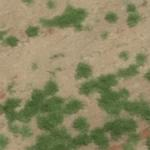
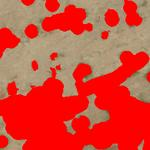
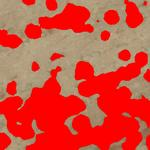
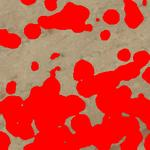
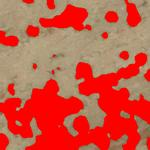
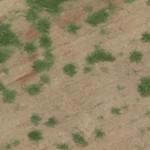
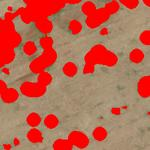
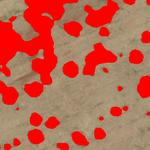
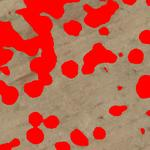
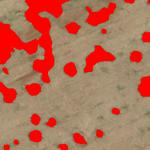
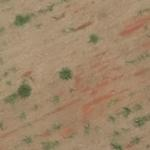
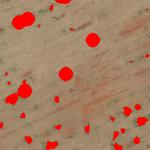
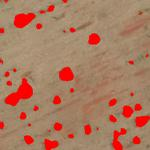
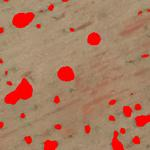
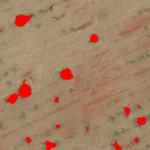
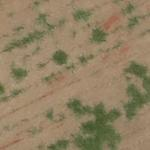
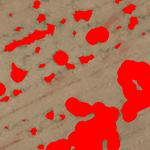
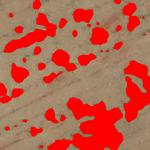
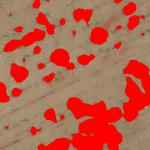
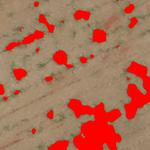
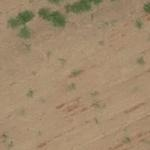
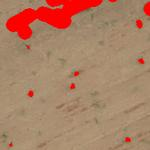
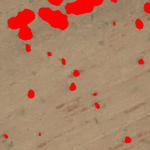
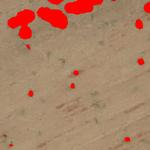
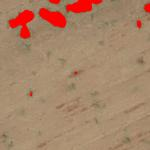

In [29]:
table